In [1]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
stocks = ['META', 'GOOGL', 'UBS']
stocks_df = {
    'META' : pd.DataFrame(),
    'GOOGL' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

In [3]:
start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Adds memory of previous with lag
def create_lag(df):
    for i in range(1, 4):
        df['Close_Lag' + str(i)] = df['Close'].shift(i)

In [5]:
# Adds a simple and exponential moving average
def create_moving_avg(df, period):
    df['SMA' + str(period)] = df['Close'].rolling(window=period).mean()
    df['EMA' + str(period)] = df['Close'].ewm(span=period, adjust=False).mean()

In [6]:
# Calculate relative strength index over 14 days
def create_RSI(df):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

In [7]:
# Drops adjusted close and open as features
def select_features(df):
    df.drop(['Open', 'Adj Close', 'High', 'Low'], axis=1, inplace=True)

In [8]:
def clean_df(df):
    create_lag(df)
    create_moving_avg(df, 5)
    create_RSI(df)
    df.dropna(inplace=True)
    select_features(df)

In [9]:
scalers = {
    'META' : None,
    'GOOGL' : None,
    'UBS' : None
}

# Scales valies using MinMax scaling
def scale_values(name, df):
    scaler = MinMaxScaler()
    scaler_target = MinMaxScaler()
    scalers[name] = scaler_target
    result = np.where(df.columns == 'Close')[0]
    cols = np.delete(df.columns, result)
    target = ['Close']
    df[cols] = scaler.fit_transform(df[cols])
    df[target] = scaler_target.fit_transform(df[target])

In [10]:
for name, df in stocks_df.items():
    clean_df(df)    

stocks_df['META'].head()

,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,SMA5,EMA5,RSI_14
Date,,,,,,,,
2012-06-07,26.309999,26159500,26.809999,25.870001,26.900000,26.722,27.018976,21.179876
2012-06-08,27.100000,38034000,26.309999,26.809999,25.870001,26.598,27.045984,24.080108
2012-06-11,27.010000,28219600,27.100000,26.309999,26.809999,26.620,27.033990,29.781104
2012-06-12,27.400000,15816800,27.010000,27.100000,26.309999,26.926,27.155993,37.771734
2012-06-13,27.270000,17102800,27.400000,27.010000,27.100000,27.018,27.193995,32.924183


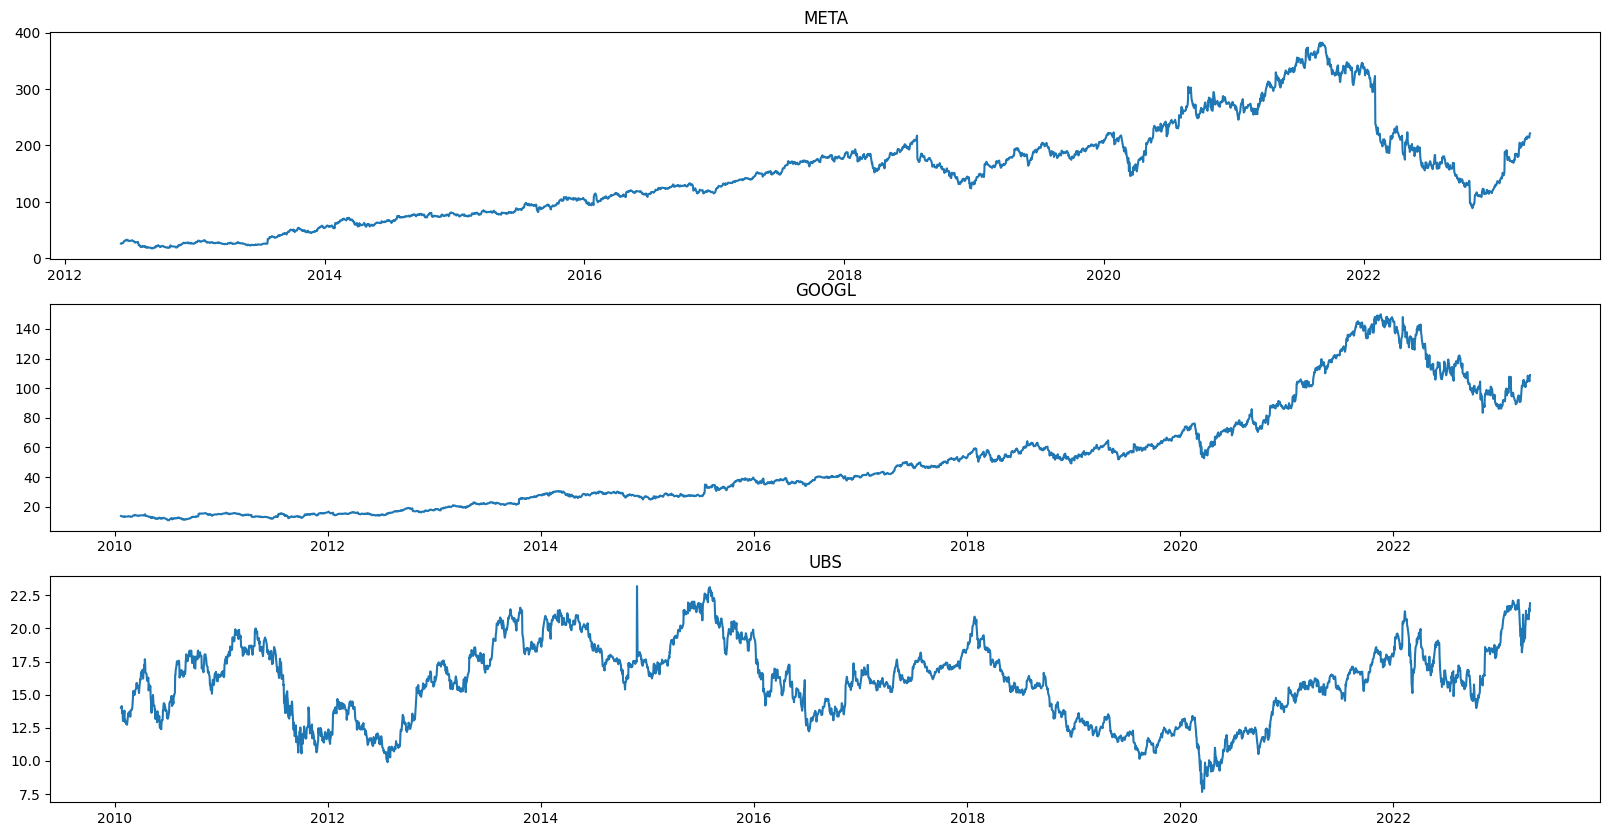

In [11]:
fig, ax = plt.subplots(3, figsize=(20, 10))

for idx, (name, df) in enumerate(stocks_df.items()):
  ax[idx].plot(df.Close)
  ax[idx].set_title(name)

In [12]:
true_data = {
    'META': None,
    'GOOGL': None,
    'UBS': None
}

for key in true_data.keys():
    
    y = stocks_df[key]['Close']
    X = stocks_df[key].drop('Close', axis=1)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42, shuffle=False)
    
    true_data[key] = {
        "X_trn" : X_train,
        "X_val" : X_val,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_val" : y_val,
        "y_tst" : y_test
    }

In [13]:
data = {
    'META': None,
    'GOOGL': None,
    'UBS': None
}

for key in data.keys():
    
    scale_values(key, stocks_df[key])
    y = stocks_df[key]['Close']
    X = stocks_df[key].drop('Close', axis=1)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42, shuffle=False)
    
    data[key] = {
        "X_trn" : X_train,
        "X_val" : X_val,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_val" : y_val,
        "y_tst" : y_test
    }


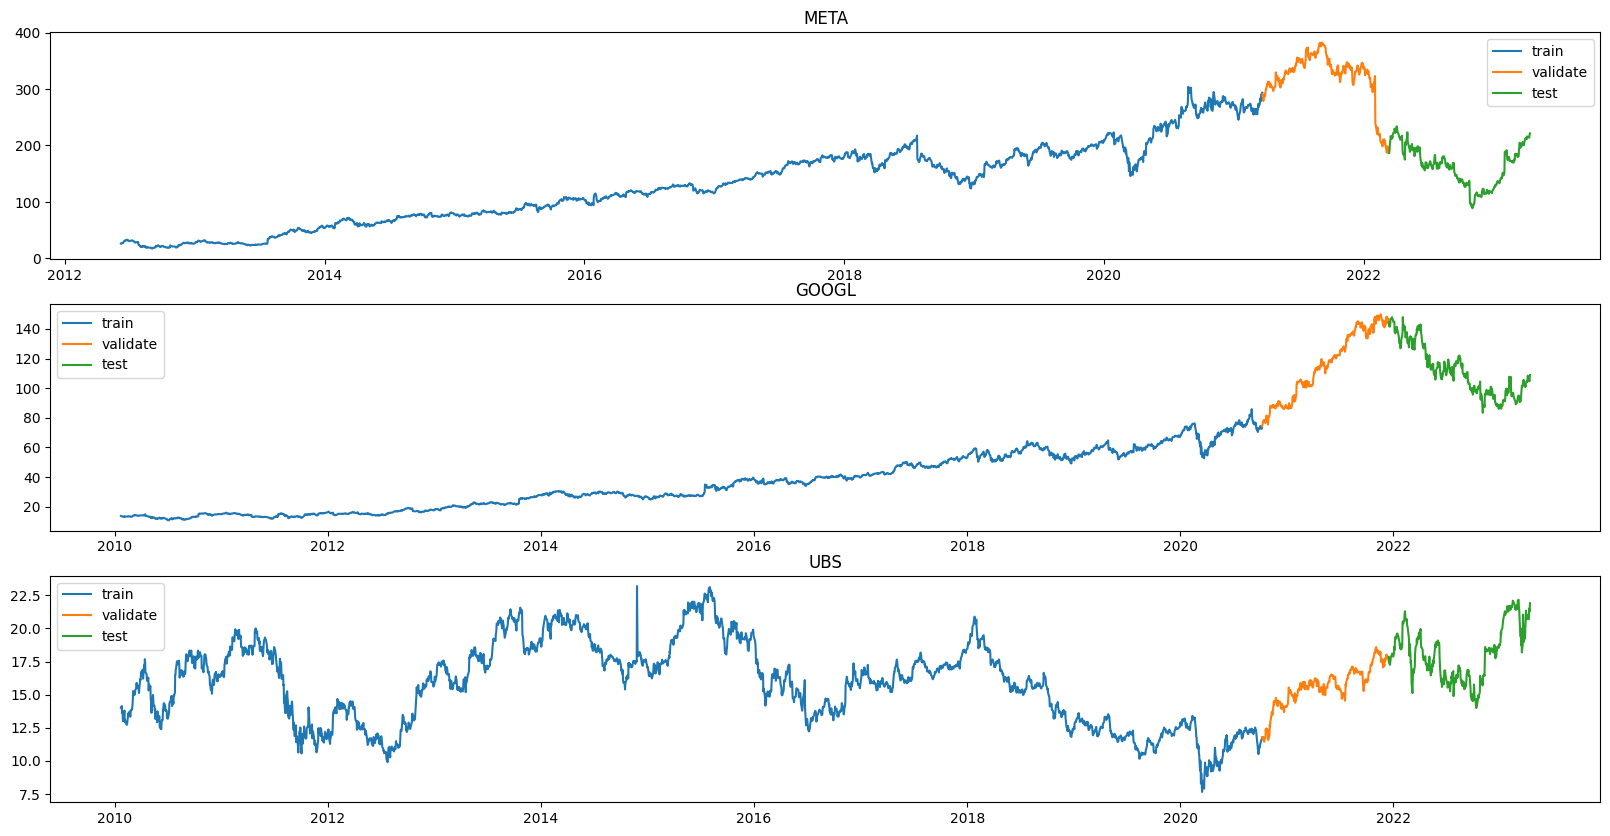

In [14]:
fig, ax = plt.subplots(3, figsize=(20, 10))

for idx, (name, vals) in enumerate(true_data.items()):
  y_trn = vals['y_trn']
  y_val = vals['y_val']
  y_tst = vals['y_tst']

  ax[idx].plot(y_trn, label='train')
  ax[idx].plot(y_val, label='validate')
  ax[idx].plot(y_tst, label='test')
  ax[idx].legend()
  ax[idx].set_title(name)

In [15]:
def create_sequences(X, y, time_steps=1):
    """
    Creates input-output pairs using sliding window approach.

    Parameters:
        -- X: numpy array, input data
        -- y: numpy array, target data
        -- time_steps: int, size of the sliding window

    Returns:
        -- X_seq: numpy array, input sequences
        -- y_seq: numpy array, output sequences
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    a, b = np.array(X_seq), np.array(y_seq)
    return np.array(X_seq), np.array(y_seq)

In [16]:
time_steps = 10

for key, value in data.items():
    
    # Create sequences for training data
    X_train_seq, y_train_seq = create_sequences(value['X_trn'], value['y_trn'], time_steps)
    # Create sequences for validation data
    X_val_seq, y_val_seq = create_sequences(value['X_val'], value['y_val'], time_steps)
    # Create sequences for test data
    X_test_seq, y_test_seq = create_sequences(value['X_tst'], value['y_tst'], time_steps)
    
    value['X_trn'] = X_train_seq
    value['X_val'] = X_val_seq
    value['X_tst'] = X_test_seq
    value['y_trn'] = y_train_seq
    value['y_val'] = y_val_seq
    value['y_tst'] = y_test_seq

In [17]:
for key, value in data.items():
    
    num_features = 7
    
    # Convert input sequences to numpy arrays
    value['X_trn'] = np.array(value['X_trn'])
    value['X_val'] = np.array(value['X_val'])
    value['X_tst'] = np.array(value['X_tst'])

    # Convert output sequences to numpy arrays
    value['y_trn'] = np.array(value['y_trn'])
    value['y_val'] = np.array(value['y_val'])
    value['y_tst'] = np.array(value['y_tst'])

    # Reshape input sequences to 3D arrays (samples, time steps, features)
    value['X_trn'] = np.reshape(value['X_trn'], (value['X_trn'].shape[0], value['X_trn'].shape[1], num_features))
    value['X_val'] = np.reshape(value['X_val'], (value['X_val'].shape[0], value['X_val'].shape[1], num_features))
    value['X_tst'] = np.reshape(value['X_tst'], (value['X_tst'].shape[0], value['X_tst'].shape[1], num_features))

Train Loss: 0.0002529369085095823
Validation Loss: 0.002386226551607251
Test Loss: 0.0010876718442887068
9/9 [==============================] - 1s 5ms/step
Train Loss: 0.0001190860421047546
Validation Loss: 0.0065801916643977165
Test Loss: 0.004381513223052025
11/11 [==============================] - 1s 7ms/step
Train Loss: 0.001051523257046938
Validation Loss: 0.0005014314083382487
Test Loss: 0.0024216363672167063
11/11 [==============================] - 1s 5ms/step


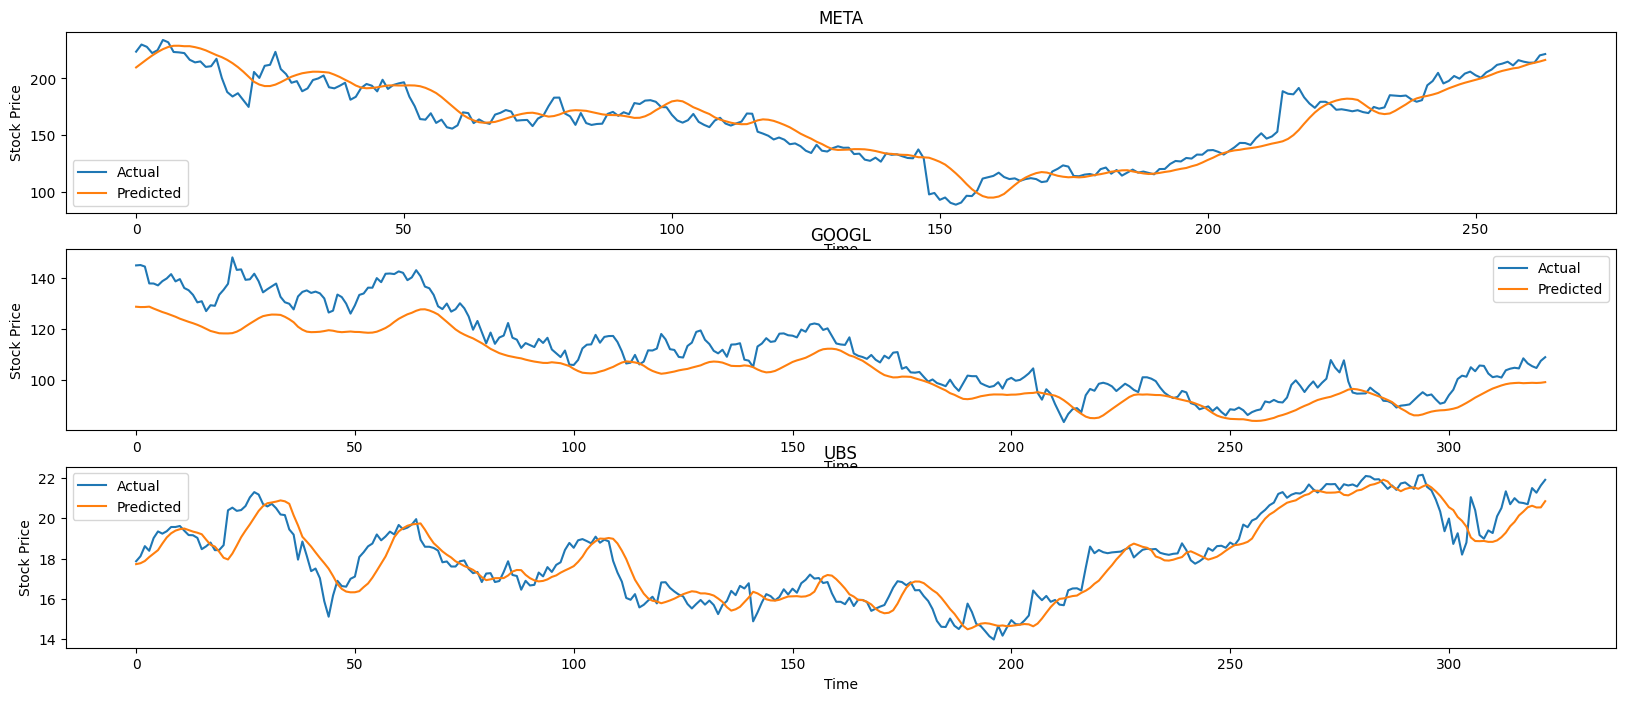

In [18]:
fig, ax = plt.subplots(3, figsize=(20, 8))

for idx, (key, val) in enumerate(data.items()): 
  X_train = val['X_trn']
  X_val = val['X_val']
  X_test = val['X_tst']
  y_train = val['y_trn']
  y_val = val['y_val']
  y_test = val['y_tst']

  # Define LSTM model
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(32))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=False)

  # Evaluate the model
  train_loss = model.evaluate(X_train, y_train, verbose=0)
  val_loss = model.evaluate(X_val, y_val, verbose=0)
  test_loss = model.evaluate(X_test, y_test, verbose=0)
  print('Train Loss:', train_loss)
  print('Validation Loss:', val_loss)
  print('Test Loss:', test_loss)
  
  # Predict stock prices using the trained model
  y_pred = scalers[key].inverse_transform(model.predict(X_test))

  # Plot actual stock prices
  ax[idx].plot(scalers[key].inverse_transform(y_test.reshape(-1, 1)), label='Actual')
  # Plot predicted stock prices
  ax[idx].plot(y_pred, label='Predicted')

  ax[idx].set_xlabel('Time')
  ax[idx].set_ylabel('Stock Price')
  ax[idx].set_title(key)
  ax[idx].legend()

### Let's compare with a linear regression

In [19]:
stocks_regression = ['META', 'GOOGL', 'UBS']
stocks_df_regression = {
    'META' : pd.DataFrame(),
    'GOOGL' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df_regression[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
for name, df in stocks_df_regression.items():
    clean_df(df)  
    scale_values(name, df)  

stocks_df_regression['META'].head()

,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,SMA5,EMA5,RSI_14
Date,,,,,,,,
2012-06-07,0.023542,0.056311,0.024914,0.022335,0.025161,0.022908,0.023771,0.133921
2012-06-08,0.025710,0.089338,0.023542,0.024914,0.022335,0.022564,0.023846,0.167956
2012-06-11,0.025463,0.062041,0.025710,0.023542,0.024914,0.022625,0.023812,0.234859
2012-06-12,0.026533,0.027545,0.025463,0.025710,0.023542,0.023474,0.024151,0.328632
2012-06-13,0.026176,0.031122,0.026533,0.025463,0.025710,0.023729,0.024257,0.271744


In [21]:
data_regression = {
    'META': None,
    'GOOGL': None,
    'UBS': None
}

for key in data_regression.keys():
    
    y = stocks_df_regression[key]['Close']
    X = stocks_df_regression[key].drop('Close', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    
    data_regression[key] = {
        "X_trn" : X_train,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_tst" : y_test
    }

In [29]:
alphas = np.arange(0, 0.1, 0.005)
best_alpha = [None, None, None]
best_pred = [None, None, None]
best_error = [float('inf'), float('inf'), float('inf')]

for idx, (key, value) in enumerate(data_regression.items()):
  for alpha in alphas:
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(value['X_trn'], value['y_trn'])
    pred = reg.predict(value['X_tst'])
    error = mean_squared_error(value['y_tst'], pred)
    if error < best_error[idx]:
      best_error[idx] = error
      best_pred[idx] = pred
      best_alpha[idx] = alpha

print(best_error)

<ipython-input-29-78e6f781e34a>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(value['X_trn'], value['y_trn'])
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.231e-02, tolerance: 1.486e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-pac

[0.00018494387803842923, 0.00031543294777368596, 0.0002402487026474152]


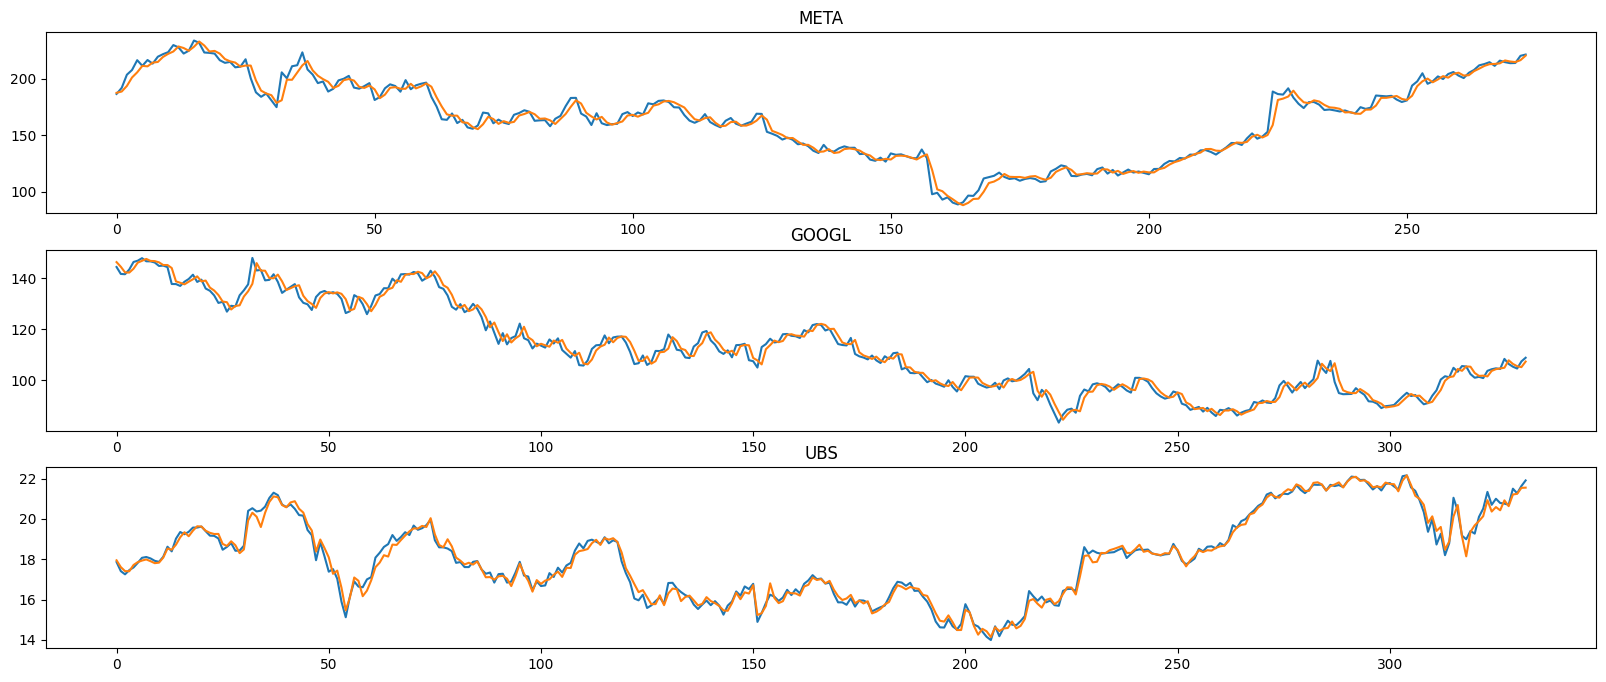

In [23]:
fig, ax = plt.subplots(3, figsize=(20, 8))

for i, (k, v) in enumerate(data_regression.items()):
  ax[i].plot(scalers[k].inverse_transform(v['y_tst'].values.reshape(-1, 1)))
  ax[i].plot(scalers[k].inverse_transform(best_pred[i].reshape(-1, 1)))
  ax[i].set_title(k)

### Interestingly, it performs just as well! Now let's try removing the paramters that we specifically added and see if it works as well.

In [24]:
stocks_regression2 = ['META', 'GOOGL', 'UBS']
stocks_df_regression2 = {
    'META' : pd.DataFrame(),
    'GOOGL' : pd.DataFrame(),
    'UBS' : pd.DataFrame()
}

start_date = '2010-01-01'
end_date = '2023-04-16'

for ticker in stocks:
    # Use yfinance library to get stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    # Add the stock data to the stock_data DataFrame
    stocks_df_regression2[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
for name, df in stocks_df_regression2.items():
    scale_values(name, df)  
    df.dropna(inplace=True)

stocks_df_regression2['META'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,0.065924,0.073021,0.056607,0.056249,0.056249,1.000000
2012-05-21,0.050743,0.050238,0.042767,0.044725,0.044725,0.285873
2012-05-22,0.039961,0.041851,0.037065,0.036411,0.036411,0.168891
2012-05-23,0.036551,0.038873,0.038227,0.039155,0.039155,0.119238
2012-05-24,0.040897,0.040813,0.039362,0.041981,0.041981,0.078082


In [26]:
data_regression2 = {
    'META': None,
    'GOOGL': None,
    'UBS': None
}

for key in data_regression2.keys():
    
    y = stocks_df_regression2[key]['Close']
    X = stocks_df_regression2[key].drop('Close', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)
    
    data_regression2[key] = {
        "X_trn" : X_train,
        "X_tst" : X_test,
        "y_trn" : y_train,
        "y_tst" : y_test
    }

In [31]:
alphas = np.arange(0, 0.1, 0.005)
best_alpha = [None, None, None]
best_pred = [None, None, None]
best_error = [float('inf'), float('inf'), float('inf')]

for idx, (key, value) in enumerate(data_regression2.items()):
  for alpha in alphas:
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(value['X_trn'], value['y_trn'])
    pred = reg.predict(value['X_tst'])
    error = mean_squared_error(value['y_tst'], pred)
    if error < best_error[idx]:
      best_error[idx] = error
      best_pred[idx] = pred
      best_alpha[idx] = alpha

print(best_error)

<ipython-input-31-77f2b344a337>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(value['X_trn'], value['y_trn'])
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-02, tolerance: 1.499e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-pac

[3.5191817584131956e-05, 0.00012651756920557377, 7.457874216619233e-05]


<ipython-input-31-77f2b344a337>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(value['X_trn'], value['y_trn'])
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.896e-02, tolerance: 1.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


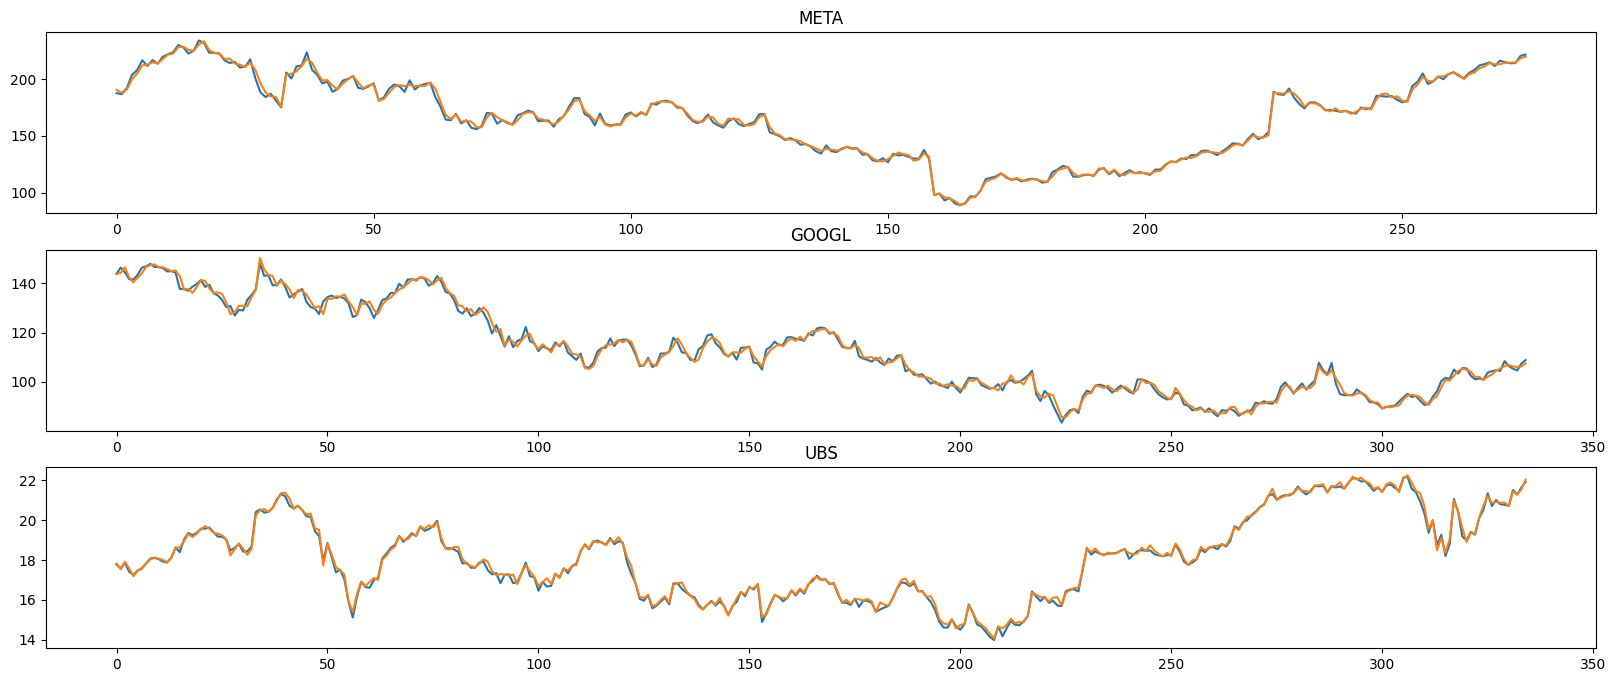

In [28]:
fig, ax = plt.subplots(3, figsize=(20, 8))

for i, (k, v) in enumerate(data_regression2.items()):
  ax[i].plot(scalers[k].inverse_transform(v['y_tst'].values.reshape(-1, 1)))
  ax[i].plot(scalers[k].inverse_transform(best_pred[i].reshape(-1, 1)))
  ax[i].set_title(k)

### Both methods worked quite well.